# EBA3500 Lecture 8. Categorical variables: Interaction and testing.

We'll use the `titanic` data set once again. 

In [142]:
!pip install pyreadr
import pyreadr, os, pathlib

def pyreadr_load(url, local_file = "temp_pyreadr.rda"):
  """Download the R dataset at the specified url into local_file, load the 
  local file, delete the local file. Return the dataset."""
  
  file_name = pyreadr.download_file(url, local_file)
  dataframe = pyreadr.read_r(file_name)
  os.remove(str(pathlib.Path().resolve()) + "/" + file_name)
  name = next(iter(dataframe.items()))[0]
  return dataframe[name]

In [143]:
url = 'https://github.com/kassambara/datarium/blob/master/data/titanic.raw.rda?raw=true'
titanic = pyreadr_load(url)
titanic.head()

,Class,Sex,Age,Survived
0,3rd,Male,Child,No
1,3rd,Male,Child,No
2,3rd,Male,Child,No
3,3rd,Male,Child,No
4,3rd,Male,Child,No


## The omnibus test

Omnibus sounds scary, but is latin for "all". It also an archaic way of saying "bus".

Recall the Titanic data. How can we test if there is a real difference in survival between the sexes? Easy, we run a *t*-test. Equivalently, we run a linear regression and look at the *p*-value of one of the category not in the baseline.

In [144]:
titanic["Survived_01"] = 1 * (titanic.Survived == "Yes")

In [145]:
x = titanic[titanic["Sex"] == "Female"]
x

,Class,Sex,Age,Survived,Survived_01
35,3rd,Female,Child,No,0
36,3rd,Female,Child,No,0
37,3rd,Female,Child,No,0
38,3rd,Female,Child,No,0
39,3rd,Female,Child,No,0
...,...,...,...,...,...
2196,Crew,Female,Adult,Yes,1
2197,Crew,Female,Adult,Yes,1
2198,Crew,Female,Adult,Yes,1
2199,Crew,Female,Adult,Yes,1


In [146]:
y = titanic[titanic["Sex"] == "Male"]
y

,Class,Sex,Age,Survived,Survived_01
0,3rd,Male,Child,No,0
1,3rd,Male,Child,No,0
2,3rd,Male,Child,No,0
3,3rd,Male,Child,No,0
4,3rd,Male,Child,No,0
...,...,...,...,...,...
1880,Crew,Male,Adult,Yes,1
1881,Crew,Male,Adult,Yes,1
1882,Crew,Male,Adult,Yes,1
1883,Crew,Male,Adult,Yes,1


In [147]:
import statsmodels.api as sm
sm.stats.ttest_ind(x.Survived_01, y.Survived_01)

(24.000594650874334, 2.98891210006274e-113, 2199.0)

The first value is the *t*-value, the second is the *p*-value. Definitely a difference between the sexes here, which we already knew from looking at the plots.

In [149]:
import numpy as np
np.mean(x["Survived_01"]) # female survivale
np.mean(y["Survived_01"]) # male survival

0.2120161756210283

In this case though, it's easier just to run a regression.

In [153]:
import statsmodels.formula.api as smf
fit = smf.ols("Survived_01 ~ Sex", data = titanic).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Survived_01   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     576.0
Date:                Thu, 14 Oct 2021   Prob (F-statistic):          2.99e-113
Time:                        10:12:10   Log-Likelihood:                -1194.1
No. Observations:                2201   AIC:                             2392.
Df Residuals:                    2199   BIC:                             2404.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7319      0.019     38.100      0.000       0.694       0.770
Sex[T.Male]    -0.5199      0.022    -24.001      0.000      -0.562      -0.477
==============================================================================
Omnibus:                      184.584   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.425
Skew:                           0.780   Prob(JB):                     2.50e-50
Kurtosis:                       2.756   Cond. No.                         4.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
fit.pvalues

Intercept      2.433710e-244
Sex[T.Male]    2.988912e-113
dtype: float64

The *p*-value of `Sex[T.Male]` matches the *p*-value of the *t*-test above.

But what can we do when we have more than $2$ categories? For $k$ categories, there is more than one *p*-value to look at!

In [154]:
fit = smf.ols("Survived_01 ~ Class", data = titanic).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Survived_01   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     69.35
Date:                Thu, 14 Oct 2021   Prob (F-statistic):           7.56e-43
Time:                        10:14:12   Log-Likelihood:                -1350.6
No. Observations:                2201   AIC:                             2709.
Df Residuals:                    2197   BIC:                             2732.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6246      0.025     25.171      0.000       0.576       0.673
Class[T.2nd]     -0.2106      0.036     -5.800      0.000      -0.282      -0.139
Class[T.3rd]     -0.3725      0.030    -12.422      0.000      -0.431      -0.314
Class[T.Crew]    -0.3851      0.029    -13.271      0.000      -0.442      -0.328
==============================================================================
Omnibus:                      758.455   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              292.650
Skew:                           0.727   Prob(JB):                     2.83e-64
Kurtosis:                       1.962   Cond. No.                         6.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can, using this regression output, answer probabilistic questions such as "is the coefficient $\beta_{\textrm{2nd}} = 0$?". But we can't answer the omnibus question "Is at least one of the $\beta$s (except the intercept $\beta_0$), not equal to 0?"
This question is about the usesfulness of all the entire categorical variable, not just its isolated $\beta$ coefficients.


### Look at sum of squares
Recall the definition of the $R^2$ for multiple regression models,
$$
R^2 = 1-\frac{\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{k=1}^{K}\beta_{k}x_{k}\right)^{2}}{\sum_{i=1}^{n}(y_{i}-\overline{y})^{2}}.
$$

The $R^2$ quantifies the relative reduction in the sum of squares attained by using the covariates $x_1, x_2, ..., x_k$.

Suppose we have one categorial covariate $X$ taking on values in $a_1, a_2, ..., a_K$, and we deal with the model $y = \beta_{0}+\sum_{k=2}^{K}\beta_{k}1[X=a_{k}]$. (Here the regression coefficeint for $a_1$ has been absorbed into the baseline.)

Then the $R^2$ equals
$$
1-\frac{\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{k=1}^{K}\beta_{k}1[X=a_{k}]\right)^{2}}{\sum_{i=1}^{n}(y_{i}-\overline{y})^{2}}.
$$
This $R^2$ quantifies the reduction in sum of squares obtained by including *all* the $\beta$s associated with the categorical variable $X$ in the regression model.

Thus, instead of testing whether there is a parameter that is not equal to $0$, we will test if the $R^2$ is equal to $0$.
Consider the following testing problem
$$
H_{0}:R^{2}=0,\quad H_{a}:R^{2}>0
$$
This is equivalent to
$$
H_{0}:\beta_{2}=\beta_{3}=...=\beta_{K}=0, \quad H_{a}:\beta_{i}\neq 0\textrm{ for some }i
$$
To see why, notice that $R^2 = 0$ if and only if all the $\beta_i$s, $i\geq2$,are equal to $0$. 

### Testing $R^2 = 0$
For the tests we are going to discuss to be formally correct, we will have to assume that the regression
model 
$$y = \beta_{0}+\sum_{k=2}^{K}\beta_{k}1[X=a_{k}] + \epsilon$$
is true, where the residuals $\epsilon$ are independent and normal with zero mean and the same variance. The assumptions about are not critical though, and the tests works well when the residuals aren't normally distributed.

Under these conditions, we find that, when $\beta_i = 0$ for all $i > 1$, 
$$
R^2 \sim \textrm{Beta}\left(\frac{K-1}{2},\frac{n-K}{2}\right),
$$
where $\textrm{Beta}(a,b)$ denotes the Beta distribution with parameters $a,b$. Moreover, "$\sim$" means "distributed as". 

### What does this mean?


In terms of simulation, it means that the simulated $R^2$ will have a histogram that approximates the density of a $\textrm{Beta}\left(\frac{K-1}{2},\frac{n-K}{2}\right)$-distributed variable arbitrarily well when the number of simulations go to infinity. 

The simulated values have to be from the null-hypothesis, i.e., they must be normally distributed with some mean $\mu$ and standard deviation $\sigma$.

In [155]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(seed = 313)
n_reps = 10 ** 4

n = 20
K = K
y = rng.normal(0, 1, (n_reps, n))
y

array([[-0.10476825,  1.200623  , -0.38544127, ..., -0.36334591,
        -0.79925663, -0.85709784],
       [ 1.57469391, -1.13584913,  2.15868501, ..., -1.00557318,
        -0.66484784, -0.31447754],
       [ 0.90012285,  1.01632256, -0.20860774, ...,  2.05125315,
        -0.61617816,  1.88551235],
       ...,
       [-0.49747136, -0.56413613,  0.08626853, ...,  0.92477878,
        -1.02178499, -0.52129338],
       [ 0.43491177,  0.43304638, -1.3601706 , ..., -0.60534607,
         0.60160771, -0.39902685],
       [-0.44078295, -0.07041964,  1.55085301, ...,  1.03522783,
         0.67758851,  0.86163172]])

Let's simulate some $R^2$s from a subset of the Titanic data.

In [156]:
import statsmodels.formula.api as smf
titanic_2 = titanic.sample(n)

def func1d(y):
  titanic_2.y = y
  fit = smf.ols("y ~ Class", data = titanic_2).fit()
  return fit.rsquared

rsqs = np.apply_along_axis(
    func1d = func1d,
    axis = 1,
    arr = y
)

rsqs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


array([0.06004274, 0.11528575, 0.01384137, ..., 0.10826497, 0.04976875,
       0.03199749])

In [159]:
K = len(set(titanic_2.Class))
K

3

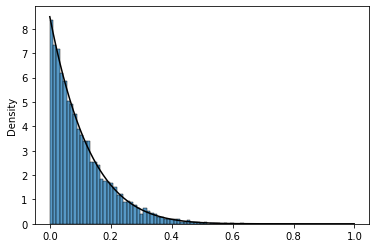

In [160]:
ax = sns.histplot(x = rsqs, stat = "density")
xs = np.arange(0, 1, 0.001)
ax.plot(xs, stats.beta.pdf(xs, (K-1)/2, (n-K)/2), color = "black")

If the null-hypothesis is true, the simulated $R^2$s will look just like this!

### Applying it

The *p*-value of a positive test statistic $T$ is $P(T\geq t)$, where $t$ is the observed value. In our case, we found that 

In [106]:
fit.rsquared

0.08650663499174571

How unlikely is this this $R^2$ if the null-hypothesis is true?

Using [`scipy.stats.beta`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html), we can finds the probability that $R^2\geq0.0865$.

In [141]:
n = titanic.shape[0]
K = 4
# sf is the "survival function" P(T > t).
stats.beta.sf(fit.rsquared, (K - 1)/2, (n - K)/2)

1.1102230246251565e-16

This *p*-value turns out to be extremely inaccurate. The value I got using `R` is `7.226502e-43`, many orders of magnitude smaller.

**Conclusion:** Reject the null-hypothesis that $\beta_i = 0$ for all $i > 1$, in other words, the categorical variable `Class` matters!

### The $F$-test
An $F$-test is a generic term for a testing problem where the distribution of the test statistic is [$F$-distributed](https://en.wikipedia.org/wiki/F-distribution). We care about the $F$-distributed statistic above because it equals $0$ if and only if $R^2$ is equal to 0. The distribution of $R^2$ is not commonly used, for reason I do not fathom. Instead, everyone uses the $F$-test. You can find its output in e.g. `statsmodels`.

We can write down the test statistic for the $F$ distribution in several ways. This one is especially convenient for us:
$$
\frac{n-K}{K-1}\frac{R^{2}}{1-R^{2}} \sim F(K-1, n - K)
$$

The $F$ tests takes two parameters, $d_1$ and $d_2$, called the degrees of freedom. In this case, $d_1 = K-1$ and $d_2 = n - K$. The parameter $d_1$ is sometimes called the numerator degree of freedom, $d_2$ the denominator degree of freedom.

**Note:**
I didn't misspell the names of $d_1$ and $d_2$. They are given these names since the $F$ statistic can be written in a different way, where $n-K$ is the denominator and $K-1$ the numerator. See e.g. the wikipedia page about the $F$-distribution. 



Using the $F$-test, we can test exactly the same null-hypothesis as we did with the Beta distribution. Python manages to calculate the *p*-value accurately in this case, namely:

In [136]:
fit.f_pvalue

7.55923138291284e-43

We will continue to discuss the $F$-test - and its connection to $R^2$ - in the nest lecture. Now we'll discuss interaction!

## Interaction

Interactions are regression terms that involve products of two or more different predictors, e.g., $y = \alpha + \beta_1 x_1 + \beta_{12} x_1x_2$. The terminology is most freqently used for categorical variables. Let's explore what it means.

### The Cartesian product

We'll have to deal with another fundamental set-theoretic construction, called the *Cartesian product*. 

**Note:** If something is *Cartesian*, it is named after the French reneissance philosopher René Descartes.

We will use the symbol "$\in$", which reads reads "in". Writing "$a\in A$" means the same as "$a \textrm{ in } A$". This symbol may look unfamiliar but is a staple of mathematical notation.

#### Definition
> Let $A$ and $B$ be two sets. The *Cartesian product*, denoted by $A\times B$, is the unique set containing the tuples $(a,b)$ for $a\in A$ and $b \in B$. 

We also call $A \times B$ the *product set*, or the product of $A$ and $B$. 

#### Example

Recall the sex and class categories from the Titanic data set.

In [4]:
set(titanic.Sex)

{'Female', 'Male'}

In [5]:
set(titanic.Class)

{'1st', '2nd', '3rd', 'Crew'}

We will construct the product set of these two sets. To to this, we will use the `product` function from `itertools`. This function often comes in handy in programming in general.

In [6]:
from itertools import product
set(product(set(titanic.Sex), set(titanic.Class)))

{('Female', '1st'),
 ('Female', '2nd'),
 ('Female', '3rd'),
 ('Female', 'Crew'),
 ('Male', '1st'),
 ('Male', '2nd'),
 ('Male', '3rd'),
 ('Male', 'Crew')}

We can also take the product of more than two sets, say $A\times B \times C$. Such products are defined in the obvious way, i.e., $(a,b,c)\in A\times B\times C$ if and only if $a\in A$, $b \in B$, and $c \in C$.

In [46]:
set(titanic.Age)

{'Adult', 'Child'}

In [47]:
set(product(set(titanic.Sex), set(titanic.Class), set(titanic.Age)))

{('Female', '1st', 'Adult'),
 ('Female', '1st', 'Child'),
 ('Female', '2nd', 'Adult'),
 ('Female', '2nd', 'Child'),
 ('Female', '3rd', 'Adult'),
 ('Female', '3rd', 'Child'),
 ('Female', 'Crew', 'Adult'),
 ('Female', 'Crew', 'Child'),
 ('Male', '1st', 'Adult'),
 ('Male', '1st', 'Child'),
 ('Male', '2nd', 'Adult'),
 ('Male', '2nd', 'Child'),
 ('Male', '3rd', 'Adult'),
 ('Male', '3rd', 'Child'),
 ('Male', 'Crew', 'Adult'),
 ('Male', 'Crew', 'Child')}

### Titanic and interaction


Recall from the last lecture that both sex and class affects the probability of survival. 

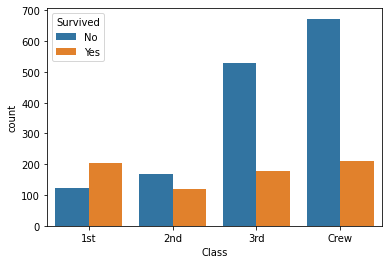

In [7]:
import seaborn as sns
sns.countplot(x="Class", hue="Survived", data=titanic)

The basic model involves only *linear effects*
$$
y = \beta_0 + \beta_{\textrm{male}}1[\textrm{sex} = \textrm{male}] + \beta_{\textrm{2nd}}1[\textrm{class} = \textrm{2nd}]+ \beta_{\textrm{3rd}}1[\textrm{class} = \textrm{3rd}] + \beta_{\textrm{Crew}}1[\textrm{class} = \textrm{crew}].
$$



Let's fit it and see what we get.

In [8]:
import statsmodels.formula.api as smf
fit = smf.ols("Survived_01 ~ Sex + Class", data = titanic).fit()
fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     I(1 * (Survived == 'Yes'))   R-squared:                       0.246
Model:                                    OLS   Adj. R-squared:                  0.245
Method:                         Least Squares   F-statistic:                     179.4
Date:                        Thu, 14 Oct 2021   Prob (F-statistic):          4.09e-133
Time:                                05:22:12   Log-Likelihood:                -1139.0
No. Observations:                        2201   AIC:                             2288.
Df Residuals:                            2196   BIC:                             2317.
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9001      0.026     34.739      0.000       0.849       0.951
Sex[T.Male]      -0.4974      0.023    -21.575      0.000      -0.543      -0.452
Class[T.2nd]     -0.1737      0.033     -5.258      0.000      -0.238      -0.109
Class[T.3rd]     -0.2887      0.028    -10.489      0.000      -0.343      -0.235
Class[T.Crew]    -0.1761      0.028     -6.270      0.000      -0.231      -0.121
==============================================================================
Omnibus:                      222.654   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              293.437
Skew:                           0.891   Prob(JB):                     1.91e-64
Kurtosis:                       2.836   Cond. No.                         7.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we check how well the estimates match the data. First we'll take a look at the predicted values of the model.

In [48]:
import pandas as pd
records = sorted(list(product(set(titanic.Sex), set(titanic.Class))))
records

[('Female', '1st'),
 ('Female', '2nd'),
 ('Female', '3rd'),
 ('Female', 'Crew'),
 ('Male', '1st'),
 ('Male', '2nd'),
 ('Male', '3rd'),
 ('Male', 'Crew')]

In [49]:
frame = pd.DataFrame.from_records(records, columns = ["Sex", "Class"])
fit.predict(frame)

0    0.972414
1    0.877358
2    0.459184
3    0.869565
4    0.344444
5    0.139665
6    0.172549
7    0.222738
dtype: float64

This is just a list of floats with no names. Let's merge it with the `frame` to make stuff clearer

In [10]:
frame["Predicted"] = fit.predict(frame)
frame

,Sex,Class,Predicted
0,Female,1st,0.900080
1,Female,2nd,0.726416
2,Female,3rd,0.611412
3,Female,Crew,0.723988
4,Male,1st,0.402714
5,Male,2nd,0.229050
6,Male,3rd,0.114046
7,Male,Crew,0.226622


Let's compare these predictions to the means using the `groupby` method.

In [51]:
titanic["Survived_01"] = 1 * (titanic.Survived == "Yes")

In [56]:
means = titanic.groupby(["Sex", "Class"]).mean()["Survived_01"]
means

Sex     Class
Female  1st      0.972414
        2nd      0.877358
        3rd      0.459184
        Crew     0.869565
Male    1st      0.344444
        2nd      0.139665
        3rd      0.172549
        Crew     0.222738
Name: Survived_01, dtype: float64

This table is simple enough. The mean on the column to the right is the mean of the subgroup for the corresponding sex and class on the right.

Let's compare these means to the predicted values of our model.

In [52]:
import numpy as np
frame["Mean"] = means.array
frame

,Sex,Class,Mean
0,Female,1st,0.972414
1,Female,2nd,0.877358
2,Female,3rd,0.459184
3,Female,Crew,0.869565
4,Male,1st,0.344444
5,Male,2nd,0.139665
6,Male,3rd,0.172549
7,Male,Crew,0.222738


Why aren't the values equal? First, notice that there are $8$ means, but only $5$ parameters in the regression output. Second, the model doens't take *interactions* into account, only linear effects. Interactions occur when the effect of one variable depends on the value of another variable.


### A "two-way" model

Let $A$ and $B$ be sets with $I$ and $J$ elements each. Consider the following model
$$y=\sum_{i=1}^{I}\sum_{j=1}^{J}\beta_{ij}1[X_{1}=a_{j}]1[X_{2}=b_{k}].$$
That is the same model as 
$$y=\sum_{i=1}^{I}\sum_{j=1}^{J}\beta_{ij}1[X = (a_{j}, b_{k})],$$
where $(a_i,b_j) \in A\times B$. Thus it may be viewed as an ordinary categorical variable model.

### Titanic example

Let $A = \{\textrm{female}, \textrm{male}\}$ and $B = \{\textrm{2nd},\textrm{3rd}, \textrm{3rd}, \textrm{Crew}\}$. That is, $A$ are the sex categories and $B$ are the class categories. Remember their product set, which equals


In [13]:
set(product(set(titanic.Sex), set(titanic.Class)))

{('Female', '1st'),
 ('Female', '2nd'),
 ('Female', '3rd'),
 ('Female', 'Crew'),
 ('Male', '1st'),
 ('Male', '2nd'),
 ('Male', '3rd'),
 ('Male', 'Crew')}

Writing down the model explicitly doesn't help, as it's cumbersome to look at. But using $$y=\sum_{i=1}^{I}\sum_{j=1}^{J}\beta_{ij}1[X = (a_{j}, b_{k})],$$
where $(a_i,b_j) \in A\times B$, we can write a table of the corresponding coefficients.

|         |        | Class |     |     |      |
| ---     |------- | ----- | --- |-----| ---  |
|         |        | 1st   | 2nd | 3rd | Crew |
| **Sex** |        |       |     |     |      |
|         | Female | $\beta_{11}$ | $\beta_{12}$ | $\beta_{13}$ | $\beta_{14}$     |
|         | Male   | $\beta_{21}$ | $\beta_{22}$ | $\beta_{23}$ | $\beta_{24}$     |

When you want to predict the probability of survival for a male passenger traveling 3rd class, you find the second row (male) and third column (3rd class), and use the $\beta_{23}$ coefficient. 

Now let's fit the model! To do this, we will define a new column in the data frame `titanic` containing the product set of `Sex` and `Class`.

In [22]:
titanic["SexClass"] = list(zip(titanic["Sex"], titanic["Class"]))
titanic.SexClass

0          (Male, 3rd)
1          (Male, 3rd)
2          (Male, 3rd)
3          (Male, 3rd)
4          (Male, 3rd)
             ...      
2196    (Female, Crew)
2197    (Female, Crew)
2198    (Female, Crew)
2199    (Female, Crew)
2200    (Female, Crew)
Name: SexClass, Length: 2201, dtype: object

Now we're ready to run the model.

In [24]:
fit = smf.ols("Survived_01 ~ SexClass - 1", data = titanic).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Survived_01   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     116.6
Date:                Thu, 14 Oct 2021   Prob (F-statistic):          1.01e-145
Time:                        05:27:26   Log-Likelihood:                -1102.0
No. Observations:                2201   AIC:                             2220.
Df Residuals:                    2193   BIC:                             2266.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
SexClass[('Female', '1st')]      0.9724      0.033     29.278      0.000       0.907       1.038
SexClass[('Female', '2nd')]      0.8774      0.039     22.586      0.000       0.801       0.954
SexClass[('Female', '3rd')]      0.4592      0.029     16.074      0.000       0.403       0.515
SexClass[('Female', 'Crew')]     0.8696      0.083     10.427      0.000       0.706       1.033
SexClass[('Male', '1st')]        0.3444      0.030     11.555      0.000       0.286       0.403
SexClass[('Male', '2nd')]        0.1397      0.030      4.672      0.000       0.081       0.198
SexClass[('Male', '3rd')]        0.1725      0.018      9.743      0.000       0.138       0.207
SexClass[('Male', 'Crew')]       0.2227      0.014     16.351      0.000       0.196       0.249
==============================================================================
Omnibus:                      286.377   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.796
Skew:                           1.059   Prob(JB):                     3.80e-90
Kurtosis:                       2.963   Cond. No.                         6.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see how these new coefficients match the means we just calculated.

In [32]:
frame["NewPredicted"] = fit.params.array
frame

,Sex,Class,Predicted,Mean,NewPredicted
0,Female,1st,0.900080,0.972414,0.972414
1,Female,2nd,0.726416,0.877358,0.877358
2,Female,3rd,0.611412,0.459184,0.459184
3,Female,Crew,0.723988,0.869565,0.869565
4,Male,1st,0.402714,0.344444,0.344444
5,Male,2nd,0.229050,0.139665,0.139665
6,Male,3rd,0.114046,0.172549,0.172549
7,Male,Crew,0.226622,0.222738,0.222738


That's perfect!

As it happens, `statsmodels` allows us to run interaction models such as these easily. We just need to use the `*` command:

In [33]:
import statsmodels.formula.api as smf
fit = smf.ols("Survived_01 ~ Sex * Class", data = titanic).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Survived_01   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     116.6
Date:                Thu, 14 Oct 2021   Prob (F-statistic):          1.01e-145
Time:                        05:37:30   Log-Likelihood:                -1102.0
No. Observations:                2201   AIC:                             2220.
Df Residuals:                    2193   BIC:                             2266.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.9724      0.033     29.278      0.000       0.907       1.038
Sex[T.Male]                  -0.6280      0.045    -14.071      0.000      -0.715      -0.540
Class[T.2nd]                 -0.0951      0.051     -1.860      0.063      -0.195       0.005
Class[T.3rd]                 -0.5132      0.044    -11.715      0.000      -0.599      -0.427
Class[T.Crew]                -0.1028      0.090     -1.146      0.252      -0.279       0.073
Sex[T.Male]:Class[T.2nd]     -0.1097      0.066     -1.655      0.098      -0.240       0.020
Sex[T.Male]:Class[T.3rd]      0.3413      0.056      6.109      0.000       0.232       0.451
Sex[T.Male]:Class[T.Crew]    -0.0189      0.096     -0.197      0.844      -0.206       0.169
==============================================================================
Omnibus:                      286.377   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.796
Skew:                           1.059   Prob(JB):                     3.80e-90
Kurtosis:                       2.963   Cond. No.                         24.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Yet again, we have to think about baselines. Since there is no `Sex[T.Female]` in the table, the baseline sex is female. Since there is no `Class[T.1st]` in the table, the baseline class if 1st class.

To calculate the predicted value of, say, a male with class `3rd`, you would have to sum the coefficients of `Sex[T.Male]`, `Class[T.3rd]` *and* `Sex[T.Male]:Class[T.3rd]`. 

In [34]:
fit.params

Intercept                    0.972414
Sex[T.Male]                 -0.627969
Class[T.2nd]                -0.095055
Class[T.3rd]                -0.513230
Class[T.Crew]               -0.102849
Sex[T.Male]:Class[T.2nd]    -0.109724
Sex[T.Male]:Class[T.3rd]     0.341335
Sex[T.Male]:Class[T.Crew]   -0.018858
dtype: float64

In [37]:
coef = fit.params
coef["Intercept"] + coef["Sex[T.Male]"] + coef["Class[T.3rd]"]+ coef["Sex[T.Male]:Class[T.3rd]"]

0.17254901960784796

In [45]:
frame[6:7]

,Sex,Class,Predicted,Mean,NewPredicted
6,Male,3rd,0.114046,0.172549,0.172549


It's clearly harder to interpret the coefficients of a the `statsmodels` object with formula `"Survived_01 ~ Sex * Class"` than that with formula `"Survived_01 ~ SexClass - 1"`. However, we may use the formulation `"Survived_01 ~ Sex * Class"` to more easily ask meaningful questions.




Most importantly, do we need the interaction terms or not? In other words, do we need the whole model `"Survived_01 ~ Sex * Class"`, or would it suffice with `"Survived_01 ~ Sex + Class"`? That's the topic for next lesson.

## Summary
1. We can test if at least one of the coefficients $\beta \neq 0$ using the $F$-test.
2. Using the $F$-test is equivalent to testing if the $R^2$ is greater than $0$.
3. Interactions is the statistical term for a model involving products of two or more variables $x_1,x_2$, e.g. $y = \beta x_1 + \beta_{12} x_1 x_2$.